In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '')

In [3]:
os.listdir(dataset_dir)
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [4]:
sample_file = os.path.join(train_dir, 'csharp/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [7]:
for name in raw_train_ds.class_names:
    print("{}".format( name))

csharp
java
javascript
python


In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [9]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [10]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, 'blank', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [15]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
embedding_dim = 16

In [19]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 softmax (Softmax)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                        

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/25
200/200 [==============================] - 3s 14ms/step - loss: 1.3878 - accuracy: 0.2542 - val_loss: 1.3874 - val_accuracy: 0.2331
Epoch 2/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3854 - accuracy: 0.2597 - val_loss: 1.3856 - val_accuracy: 0.2794
Epoch 3/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3845 - accuracy: 0.2663 - val_loss: 1.3845 - val_accuracy: 0.3481
Epoch 4/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3834 - accuracy: 0.2892 - val_loss: 1.3834 - val_accuracy: 0.3644
Epoch 5/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3822 - accuracy: 0.3144 - val_loss: 1.3821 - val_accuracy: 0.3787
Epoch 6/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3808 - accuracy: 0.3391 - val_loss: 1.3806 - val_accuracy: 0.4006
Epoch 7/25
200/200 [==============================] - 1s 3ms/step - loss: 1.3792 - accuracy: 0.3647 - val_loss: 1.3789 - val_accuracy: 0.4112
Epoch

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 6s 24ms/step - loss: 1.2896 - accuracy: 0.5385
Loss:  1.2896100282669067
Accuracy:  0.5385000109672546


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

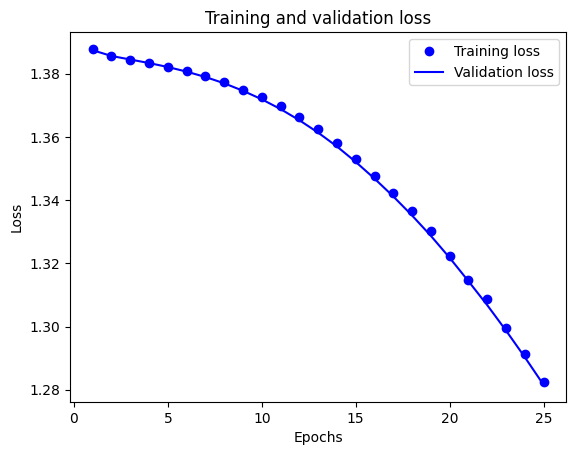

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

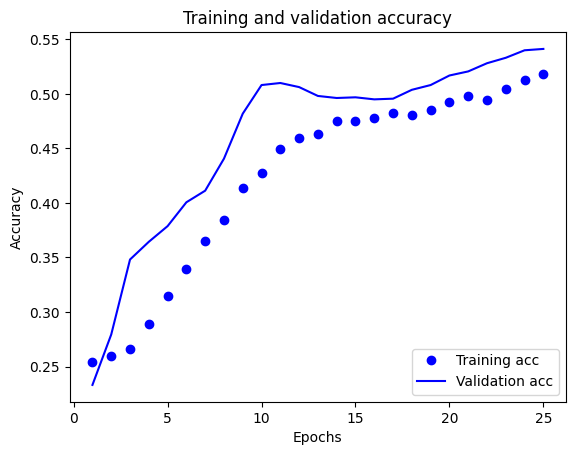

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [26]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

C:\Users\knudi\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 2s 5ms/step - loss: 1.2896 - accuracy: 0.5385
0.5385000109672546


In [27]:
import math as mt

predictions = export_model.predict(["finding different words in two lists i have two list and i want to delete the matching one and keep the different..here is the code:..def check_synonym(text):.     tokens=regexp_tokenize(text, r'[،؟!.؛s+]s*', gaps=true).     based_text= ' '.join(cursor.execute('select request from male_conversation_engine where request regexp?',[tokens[0]]).fetchone()).     based_tokens=regexp_tokenize(str(based_text), r'[،؟!.؛s+]s*', gaps=true).    for w1 in based_tokens:.       for w2 in tokens:.           if w1 == w2:.              based_tokens.remove(w1),tokens.remove(w2)      .return list...if the two list are ""in arabic"":.. tokens = ['هذا','الجهاز','الجميل']. based_tokens = ['هذا','الجهاز','جيد']...the output should be:.. tokens = ['الجميل']. based_tokens = ['جيد']...the actual output:.. tokens = ['الجهاز','جميل']. based_tokens = ['الجهاز','جيد']...the side only delete the first element 'هذا' and return the rest of the list...(using blank3)"
])
print(predictions[0][0])
posOrNeg = round( predictions[0][0])
raw_train_ds.class_names[posOrNeg]


1/1 [==============================] - 0s 106ms/step
0.47873154


'csharp'